# Bandpass calibration demonstration

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from arl.data_models.parameters import arl_path

results_dir = arl_path('test_results')

from matplotlib import pylab

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt

from arl.processing_components import create_blockvisibility, apply_gaintable, copy_visibility, solve_gaintable, \
    convert_blockvisibility_to_visibility, convert_visibility_to_blockvisibility, \
    create_gaintable_from_blockvisibility, show_image, create_test_image, simulate_gaintable, \
    create_named_configuration

from arl.workflows import predict_list_serial_workflow

from arl.data_models.polarisation import PolarisationFrame

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))
mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 

Construct LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

create_named_configuration: LOWBD2-CORE
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_configuration_from_file: 166 antennas/stations


We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.zeros([1])
vnchan = 128
frequency = numpy.linspace(0.8e8, 1.2e8, vnchan)
channel_bandwidth = numpy.array(vnchan*[frequency[1]-frequency[0]])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
bvt = create_blockvisibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: created 1 times
create_blockvisibility: 1 rows, 0.106 GB


Read the venerable test image, constructing an image

import_image_from_fits: created >f4 image of shape (256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/M31.MOD = 1.006458, 0.000000
replicate_image: replicating shape (256, 256) to (128, 1, 256, 256)


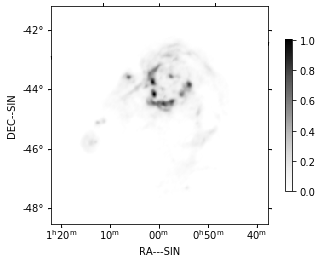

In [4]:
m31image = create_test_image(frequency=frequency, cellsize=0.0005)
nchan, npol, ny, nx = m31image.data.shape
m31image.wcs.wcs.crval[0] = bvt.phasecentre.ra.deg
m31image.wcs.wcs.crval[1] = bvt.phasecentre.dec.deg
m31image.wcs.wcs.crpix[0] = float(nx // 2)
m31image.wcs.wcs.crpix[1] = float(ny // 2)

fig=show_image(m31image)

Predict the visibility from this image

In [ ]:
vt = convert_blockvisibility_to_visibility(bvt)
vt = predict_list_serial_workflow([vt], [m31image], context='timeslice')[0]
bvt = convert_visibility_to_blockvisibility(vt)

convert_visibility: Original 1 rows, 0.106 GB, converted 1752960 rows, 0.183 GB
fit_uvwplane: Fit to 1752960 rows reduces max abs w from 95.3 to 0.0 m
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    (14.95950601, -44.97134965)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>


Create a gain table with modest amplitude and phase errors, smootheed over 16 channels

In [ ]:
gt = create_gaintable_from_blockvisibility(bvt)
gt = simulate_gaintable(gt, phase_error=1.0, amplitude_error=0.1, smooth_channels=16)

Plot the gains applied

In [ ]:
plt.clf()
for ant in range(4):
    amp = numpy.abs(gt.gain[0,ant,:,0,0])
    plt.plot(amp)
plt.title('Amplitude of bandpass')
plt.xlabel('channel')
plt.show()

plt.clf()
for ant in range(4):
    phase = numpy.angle(gt.gain[0,ant,:,0,0])
    plt.plot(phase)
plt.title('Phase of bandpass')
plt.xlabel('channel')
plt.show()



In [ ]:
cbvt = copy_visibility(bvt)
cbvt = apply_gaintable(cbvt, gt)

Solve for the gains

In [ ]:
gtsol=solve_gaintable(cbvt, bvt, phase_only=False)

Plot the solved relative to the applied. Declare antenna 0 to be the reference. Ideally these should be amplitude 1.0
 and phase 0.0.

In [ ]:
plt.clf()
for ant in range(4):
    amp = numpy.abs(gtsol.gain[0,ant,:,0,0]/gt.gain[0,ant,:,0,0])
    plt.plot(amp)
plt.title('Relative amplitude of bandpass')
plt.xlabel('channel')
plt.show()

plt.clf()
for ant in range(4):
    refphase = numpy.angle(gtsol.gain[0,0,:,0,0]/gt.gain[0,0,:,0,0])
    phase = numpy.angle(gtsol.gain[0,ant,:,0,0]/gt.gain[0,ant,:,0,0])
    plt.plot(phase-refphase)
plt.title('Relative phase of bandpass')
plt.xlabel('channel')
plt.show()

